<a href="https://colab.research.google.com/github/glucard/Leaves-dataset/blob/dev/Colab/modelsXception_Leaves_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import os
import tensorflow as tf

# parace que tem que abrir o link com o navegador primeiro para que o download pelo colab funcione.
_URL = 'https://github.com/glucard/Leaves-dataset/archive/refs/heads/dev.zip'
path_to_zip = tf.keras.utils.get_file('Leaves-dataset-dev.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'Leaves-dataset-dev')

leaves_dataset_dir = os.path.join(PATH, 'data')
BATCH_SIZE = 30
IMG_SIZE = (299, 299)

leaves_dataset = tf.keras.utils.image_dataset_from_directory(leaves_dataset_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=IMG_SIZE,
                                                            crop_to_aspect_ratio=False,
                                                             )
leaves_dataset

Found 602 files belonging to 11 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
leaves_dataset_lenght = leaves_dataset.cardinality().numpy()

train_dataset = leaves_dataset.take(leaves_dataset_lenght//4 * 3)
#train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)

validation_dataset = leaves_dataset.skip(leaves_dataset_lenght//4 *3)
#validation_dataset = leaves_dataset.unbatch().batch(BATCH_SIZE)

In [ ]:
def image_standardization(image,label):
  """image = tf.image.per_image_standardization(image)"""
  image = tf.math.subtract(image, tf.math.reduce_mean(image))
  return image, label

train_dataset = train_dataset.map(image_standardization)
validation_dataset = validation_dataset.map(image_standardization)

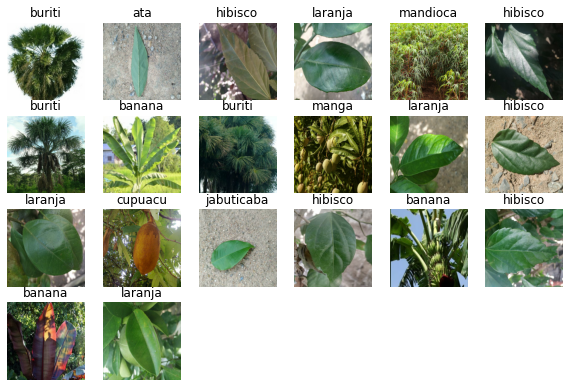

In [ ]:
import matplotlib.pyplot as plt

class_names = leaves_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(6, 6, i + 1)
    img = tf.keras.utils.array_to_img(images[i].numpy())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
print(validation_dataset)
print(val_batches)

<MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(6, shape=(), dtype=int64)


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
print(validation_dataset)
print(val_batches)
test_dataset = validation_dataset.take(val_batches // 2) # lenght//5 first elements in test_dataset
# validation_dataset = validation_dataset.skip(val_batches // 2) # skipping elements used in test_dataset

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

<MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(6, shape=(), dtype=int64)
Number of validation batches: 6
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

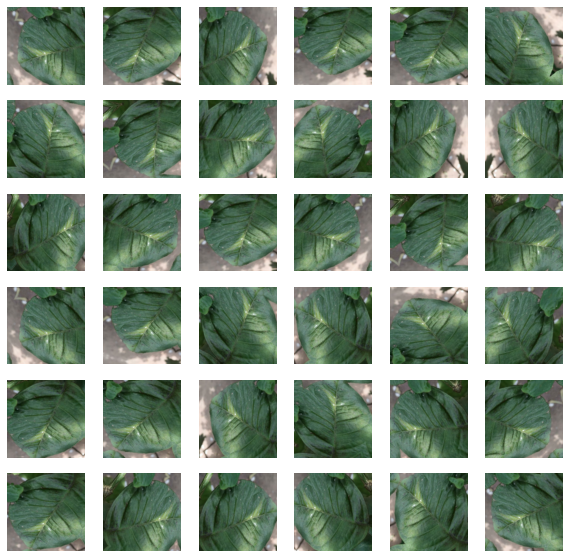

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(244, 244),
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((-0.2, 0.3)),
])

for image, _ in test_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True) # tf.expand_dims() é só pro sample ser tratado como um batch (160,160,3) -> (1,160,160,3)
    
    img = tf.keras.utils.array_to_img(augmented_image[0])

    plt.imshow(img)
    plt.axis('off')

# corrigir bug data_augmentation not working:
# https://stackoverflow.com/questions/71164259/tensorflow-augmentation-layers-not-working-after-importing-from-tf-keras-applica

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
# base_model.summary()

(299, 299, 3)


In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset)) # next(iter()) parece uma fila.
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 10, 10, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
"""conv2_layer_0 = tf.keras.layers.Conv2D(960, kernel_size=(2, 2), activation='relu',
                                       #kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3)
                                       )
conv2_layer_1 = tf.keras.layers.Conv2D(960, kernel_size=(3, 3), activation='relu',
                                       #kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3)
                                       )"""



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#flatten_layer = tf.keras.layers.Flatten()
hidden_layer_0 = tf.keras.layers.Dense(32, activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-4),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-3)
                                         )
prediction_layer = tf.keras.layers.Dense(11, activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-3),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-2)
                                         ) # não esquecer de trocar numero de classes ao alterar o dataset ou colocar a propria dimensão de classes do dataset

# adicionar mais camada de conv e é isso
"""hidden_batch = hidden_layer(feature_batch_average)
hidden_batch_1 = hidden_layer_1(hidden_batch)
hidden_batch_2 = hidden_layer_2(hidden_batch_1)
hidden_batch_3 = hidden_layer_3(hidden_batch_2)
hidden_batch_4 = hidden_layer_4(hidden_batch_3)
hidden_batch_5 = hidden_layer_5(hidden_batch_4)
hidden_batch_6 = hidden_layer_6(hidden_batch_5)
prediction_batch = prediction_layer(hidden_batch_6)"""

"""conv2_batch_0 = conv2_layer_0(feature_batch)
conv2_batch_1 = conv2_layer_1(conv2_batch_0)"""
# feature_batch_average = global_average_layer(conv2_batch_1)
"""flatten_batch = global_average_layer(feature_batch)
hidden_batch_0 = hidden_layer_0(flatten_batch)"""
prediction_batch = prediction_layer(feature_batch)

print(prediction_batch.shape)

(30, 10, 10, 11)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

"""x = tf.keras.layers.Dropout(0.2)(x)
x = conv2_layer_0(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = conv2_layer_1(x)"""

# x = global_average_layer(x)
x = global_average_layer(x)

"""x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer_0(x)"""
#x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0007
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 5s 173ms/step - loss: 3.0930 - accuracy: 0.0987
initial loss: 3.09
initial accuracy: 0.10


In [ ]:
print(model.evaluate(test_dataset))

3/3 [==============================] - 3s 216ms/step - loss: 3.0855 - accuracy: 0.1000
[3.0855095386505127, 0.10000000149011612]


In [ ]:
initial_epochs = 70

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/70
15/15 [==============================] - 13s 608ms/step - loss: 2.8067 - accuracy: 0.2156 - val_loss: 2.5252 - val_accuracy: 0.3618
Epoch 2/70
15/15 [==============================] - 8s 472ms/step - loss: 2.3077 - accuracy: 0.5267 - val_loss: 2.1443 - val_accuracy: 0.5789
Epoch 3/70
15/15 [==============================] - 8s 477ms/step - loss: 2.0176 - accuracy: 0.6600 - val_loss: 1.9156 - val_accuracy: 0.7105
Epoch 4/70
15/15 [==============================] - 8s 476ms/step - loss: 1.8054 - accuracy: 0.7289 - val_loss: 1.7567 - val_accuracy: 0.7237
Epoch 5/70
15/15 [==============================] - 10s 610ms/step - loss: 1.6434 - accuracy: 0.7711 - val_loss: 1.6485 - val_accuracy: 0.7237
Epoch 6/70
15/15 [==============================] - 8s 481ms/step - loss: 1.5353 - accuracy: 0.7911 - val_loss: 1.5398 - val_accuracy: 0.7368
Epoch 7/70
15/15 [==============================] - 10s 616ms/step - loss: 1.4466 - accuracy: 0.8289 - val_loss: 1.4494 - val_accuracy: 0.7895
Epo

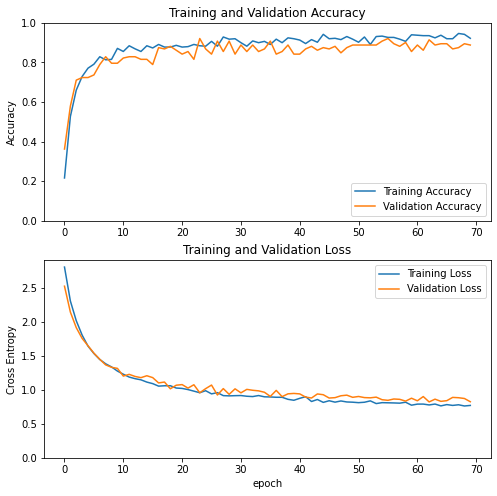

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 3s 232ms/step - loss: 0.7193 - accuracy: 0.9333


[0.719287633895874, 0.9333333373069763]

In [ ]:
from sklearn.metrics import classification_report
for images, labels in test_dataset.unbatch().batch(616).take(1):
  y_pred = np.argmax(model.predict(images), axis=1)
  print(classification_report(labels.numpy(), y_pred, target_names=class_names))

3/3 [==============================] - 1s 261ms/step
                precision    recall  f1-score   support

          acai       1.00      0.80      0.89         5
aralia_redonda       1.00      1.00      1.00        14
           ata       1.00      1.00      1.00         9
        banana       0.88      1.00      0.93         7
        buriti       0.83      1.00      0.91         5
       cupuacu       1.00      0.86      0.92         7
       hibisco       0.89      0.89      0.89         9
    jabuticaba       1.00      1.00      1.00         6
       laranja       0.93      0.93      0.93        14
      mandioca       0.83      1.00      0.91         5
         manga       1.00      0.89      0.94         9

      accuracy                           0.94        90
     macro avg       0.94      0.94      0.94        90
  weighted avg       0.95      0.94      0.94        90



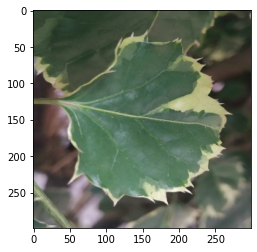

In [ ]:
from numpy import expand_dims

np.set_printoptions(suppress=True)
for imgs, labels in test_dataset.take(1):
  img = imgs[0]
plt.imshow(tf.keras.utils.array_to_img(img))

img = expand_dims(img, axis=0)

In [ ]:
"""for layer in model.layers:
 # check for convolutional layer
 if 'conv' not in layer.name:
  continue
 # get filter weights
 filters, biases = layer.get_weights()
 print(layer.name, filters.shape)"""

ixs = []
for i in range(len(base_model.layers)):
  layer = base_model.layers[i]
  # check for convolutional layer
  if 'conv2d'.upper() not in layer.name.upper():
    continue
  # summarize output shape"""
  
  ixs.append(i)
  print(i, layer.name, layer.output.shape)
print(len(ixs))

#ixs = [12, len(base_model.layers)-1]
#ixs.append(len(base_model.layers)-1)
print(ixs)

12 conv2d_8 (None, 74, 74, 128)
22 conv2d_9 (None, 37, 37, 256)
32 conv2d_10 (None, 19, 19, 728)
122 conv2d_11 (None, 10, 10, 1024)
4
[12, 22, 32, 122]


1/1 [==============================] - 1s 555ms/step
(1, 74, 74, 128)


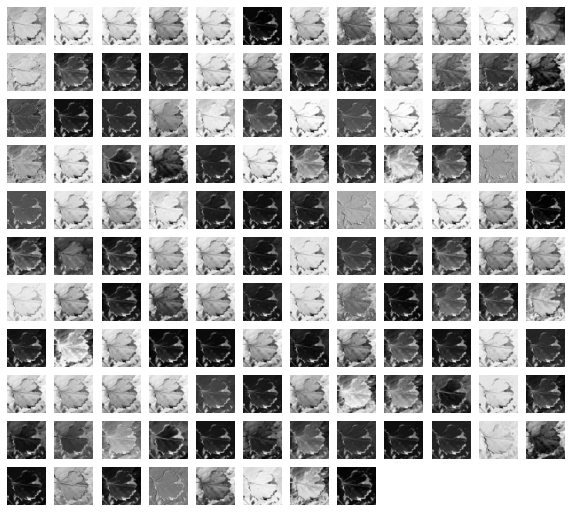

(1, 37, 37, 256)


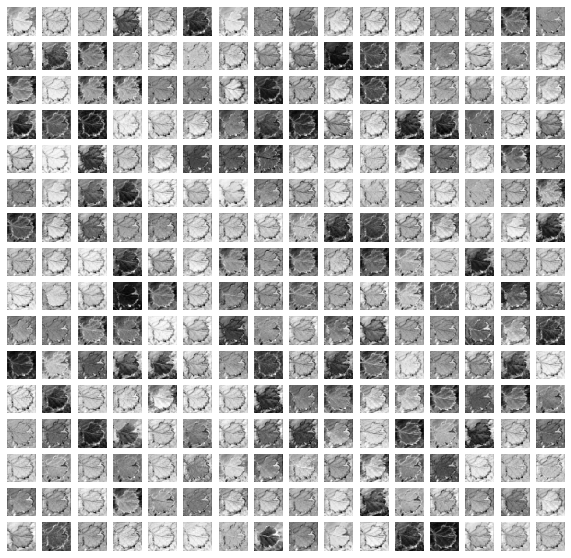

(1, 19, 19, 728)


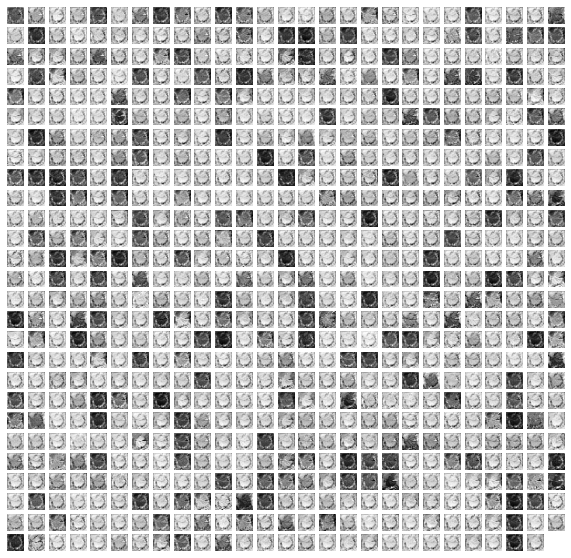

(1, 10, 10, 1024)


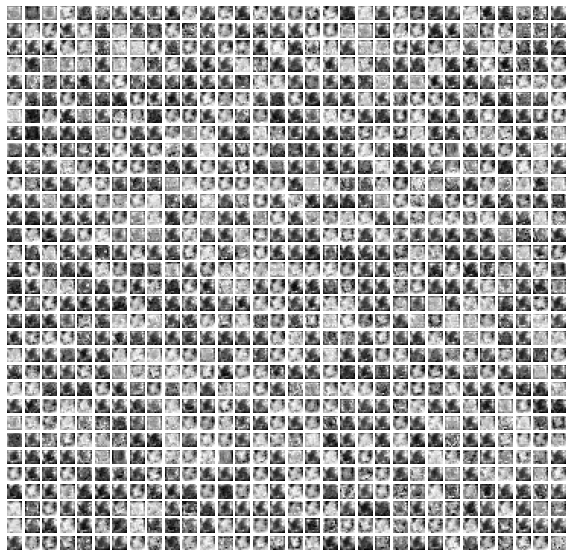

In [ ]:
from tensorflow.keras.models import Model
from matplotlib import pyplot

# load the model
# redefine model to output right after the first hidden layer
outputs = [base_model.layers[i].output for i in ixs]
model_f = Model(inputs=base_model.inputs, outputs=outputs)

# get feature map for first hidden layer
feature_maps = model_f.predict(img)
# plot the output from each block
for fmap in feature_maps:
  print(fmap.shape)
  ix = 1
  square = np.sqrt(fmap.shape[3])
  if not square.is_integer():
    square = int(square) + 1
  pyplot.figure(figsize=(10, 10))
  for _ in range(fmap.shape[3]):
      # specify subplot and turn of axis
      # ax = plt.subplot(6, 6, i + 1)
      ax = pyplot.subplot(square, square, ix)
      # plot filter channel in grayscale
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
      # show the figure
      pyplot.axis('off')
  pyplot.show()

In [ ]:
ixs = []
for i in range(len(model.layers)):
  layer = model.layers[i]
  # check for convolutional layer
  if 'conv'.upper() not in layer.name.upper():
    continue
  # summarize output shape
  
  ixs.append(i)
  print(i, layer.name, layer.output.shape)

In [ ]:
outputs = [model.layers[i].output for i in ixs]
model_f = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
 
# convert the image to an array

# get feature map for first hidden layer
feature_maps = model_f.predict(img)
# plot the output from each block
for fmap in feature_maps:
  print(fmap.shape)
  ix = 1
  square = np.sqrt(fmap.shape[3])
  if not square.is_integer():
    square = int(square) + 1
  pyplot.figure(figsize=(10, 10))
  for _ in range(fmap.shape[3]):
      # specify subplot and turn of axis
      # ax = plt.subplot(6, 6, i + 1)
      ax = pyplot.subplot(square, square, ix)
      # plot filter channel in grayscale
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
      # show the figure
      pyplot.axis('off')
  pyplot.show()

1/1 [==============================] - 0s 33ms/step
